In [17]:
import pandas as pd
import numpy as np
from time import process_time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from custom_functions import *
from custom_models import *

# Prepare Data

**1. Load train and val**

In [4]:
# D_train = read_data()
# D_test = read_data()
data = read_data("ASI_preprocessed.csv")
D_train, D_test =  train_test_split(data ,test_size=0.2, random_state=42)

x_train = D_train['tweet']
y_train = D_train['sarcasm'].values.tolist()
x_val = D_test['tweet']
y_val = D_test['sarcasm'].values.tolist()

print('\ntraining data: {}\t validation data: {}'.format(len(x_train),len(x_val)),
      '\ntraining classes: {}\t validation classes: {} \n'.format(np.unique(y_val),np.unique(y_val)))



training data: 10035	 validation data: 2509 
training classes: [False  True]	 validation classes: [False  True] 



**2. Clean and Preprocess**

In [5]:
# Clean Text
x_train = x_train.apply(lambda x : clean_text(x)).values.tolist()
x_val = x_val.apply(lambda x : clean_text(x)).values.tolist()
# Preprocess Text


# Tokenize Text
tokenizer, x_train_tokenized, x_val_tokenized = tokenize_text(data['tweet'].values.tolist(),
                                                               x_train, x_val)

print('x_train_tokenized:',len(x_train_tokenized),'\nx_val_tokenized:',len(x_val_tokenized),
      "\nTotal Vocab: ",len(tokenizer.word_counts))

x_train_tokenized: 10035 
x_val_tokenized: 2509 
Total Vocab:  52262


In [6]:
# Pad Text
maximum_text_length = 100
padding_type = "post"
truncating_type = "post"

x_train_padded = pad_text_sequence(x_train_tokenized, maximum_text_length, padding_type, truncating_type)
x_val_padded = pad_text_sequence(x_val_tokenized, maximum_text_length, padding_type, truncating_type)

print('x_train_padded:',x_train_padded.shape,'\nx_val_padded',x_val_padded.shape)

x_train_padded: (10035, 100) 
x_val_padded (2509, 100)


**3. Encode target variables (labels) to integers**



In [7]:
y_train = get_label_encoding(y_train)
y_val = get_label_encoding(y_val)

print(y_train.shape, y_val.shape)

Mapping:
False : 0 	
True : 0 	


Mapping:
False : 1 	
True : 0 	


(10035, 1) (2509, 1)


**4. Generate Embedding Matrix**

In [8]:
# Load word embeddings from file
vocab = tokenizer.word_index
embedding_dimension = 100
embeddings_file = "fasttext_model-skipgram_dim-100.vec"

embedding_matrix = get_word_embeddings(embeddings_file,vocab,embedding_dimension)

# Get sentence embeddings

# Validate embedding_matrix shape
print("Total Vocab:",len(vocab), "\nEmbeddings:",embedding_matrix.shape[0] -1 )

Total word embeddings read: 50430

Total Vocab: 52263 
Embeddings: 52263


**5. Train Model**

# Feed Forward Neural Network (FFNN)

In [9]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
FFNN_model = FFNN(input_length = input_length, input_dimension = embedding_vocab, 
                  embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                  embedding_matrix = embedding_matrix, num_layers = 3, trainable = True)

# View model summary
print("\n\nModel Summary:")
FFNN_model.summary()

# Train model
print("\n\nTraining Model:")
model_history = FFNN_model.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 100
Shape of Input layer:  10035 x 100
Output classes:  2


Model Summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          5226400   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total para

# CNN

In [11]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
CNN_model = CNN(input_length = input_length, input_dimension = embedding_vocab, 
                  embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                  embedding_matrix = embedding_matrix, num_layers = 1, trainable = False,
                   kernel_size = 5, dropout_rate = 0.25)

# View model summary
print("\n\nModel Summary:")
CNN_model.summary()

# Train model
print("\n\nTraining Model:")
model_history = CNN_model.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 100
Shape of Input layer:  10035 x 100
Output classes:  2


Model Summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          5226400   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 32)            16032     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 5,242,498
Trainable params: 16,098
Non-trainable params: 5,226,400
___________________________________________________________

# BI-LSTM 1

In [12]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
BILSTM_model = BILSTM(input_length = input_length, input_dimension = embedding_vocab, 
                   embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                   embedding_matrix = embedding_matrix, layer1 = 64, layer2 = 64, trainable = False,
                   dropout_rate = 0.25)

# View model summary
print("\n\nModel Summary:")
BILSTM_model.summary()

# Train model
print("\n\nTraining Model:")
model_history = BILSTM_model.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, batch_size = 32, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 100
Shape of Input layer:  10035 x 100
Output classes:  2


Model Summary:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          5226400   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          84480     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 5,319,266
Trainable params: 92,866
Non-trainable params: 5,226,400
___________________________________________________________

# BI-LSTM 2

In [13]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
BILSTM_model2 = BILSTM_2(input_length = input_length, input_dimension = embedding_vocab, 
                   embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                   embedding_matrix = embedding_matrix)

# View model summary
print("\n\nModel Summary:")
BILSTM_model2.summary()

# Train model
print("\n\nTraining Model:")
model_history = BILSTM_model2.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, batch_size = 32, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 100
Shape of Input layer:  10035 x 100
Output classes:  2


Model Summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          5226400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 100)          20100     
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total pa

**6. Evaluate Model**

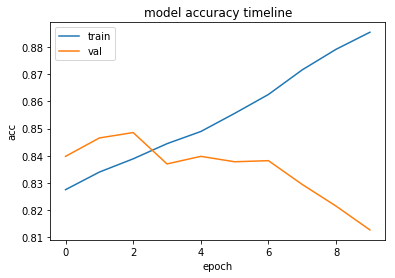

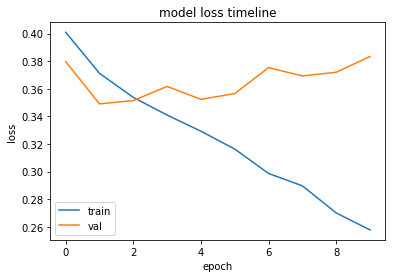


Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.87      0.88      2074
           1       0.47      0.54      0.50       435

    accuracy                           0.81      2509
   macro avg       0.68      0.70      0.69      2509
weighted avg       0.82      0.81      0.82      2509



In [24]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(BILSTM_model2.predict(x_val_padded),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

In [ ]:
# save model
save_model(BILSTM_model2, "ASI_Sarcasm_BiLSTM2")